In [17]:
import tensorflow as tf
import sys
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import pandas as pd

path = "../../"
model_path = path + "models/"
test_path = path + "data/test/"
model_path_cull = model_path + "cull%i/" % 5
devtest_path = path + "data/cull5/model_data/"
fasta_seq_path = test_path + "casp11.fasta"
pdb_path = test_path + "casp11.targets_refine/"

sys.path.insert(0, model_path + "model_functions")
sys.path.insert(0, path + "preprocess")

import primary_model as pm
import fasta_to_1_hot_encodings as fthe
import get_contact_maps as gcm
import visualization as tv
import eval_metrics as em


%matplotlib inline
importlib.reload(gcm)
importlib.reload(fthe)
importlib.reload(tv)
importlib.reload(em)

<module 'eval_metrics' from '../../models/model_functions/eval_metrics.py'>

In [6]:
"""
Visualize the results of applying the model to 
the test CASP data.

So far, we will visualize:
    contact maps (predicted, and actual)
"""


import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib


def make_prediction(model, fasta_seqs):
    """
    Given fasta sequences, make the contact map 
    predictions
    """
    
    cmap_predictions = dict()
    
    for pdb_id, aa_seq in fasta_seqs.items():
        one_hot = aa_seq.reshape((1,) + aa_seq.shape)
        c_map_pred = model.predict(one_hot)
        length = one_hot.shape[1]
        c_map_pred = c_map_pred.reshape((length, length))
        cmap_predictions[pdb_id] = c_map_pred
        
    return cmap_predictions
    
def plot_contact_maps(c_maps_preds, c_maps, save_dir=None):
    """
    Plot the actual contact maps
    and the predicted contact maps.

    :param c_maps_preds: dictionary mapping PDB ID to predicted c_maps
    :type  c_maps_preds: dict
    :param c_maps: dictionary mapping PDB ID to c_map
    :type  c_maps: dict
    :param save_dir: directory to save plots
    :type  save_dir: str
    """

    for pdb_id, cmap in c_maps.items():
        c_map_pred = c_map_preds[pdb_id]
        
        fig = plt.figure(figsize=(20, 10))
        fig.suptitle("PDB ID: " + pdb_id)

        ax1 = plt.subplot(221)
        ax1.set_title("Predicted: ")
        plt.imshow(c_map_pred > 0.5)

        ax2 = plt.subplot(222)
        ax2.set_title("Actual: ")
        plt.imshow(cmap)

        if save_dir != None:
            import os
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            plt.savefig(save_dir + pdb_id + "_cmap.png")


# if __name__ == "__main__":
#     import logging
#     import argparse

#     parser = argparse.ArgumentParser(
#         description='Visualize the results of the trained model.')

#     parser.add_argument(
#         'model_path', 
#         type=str,
#         help='Path to the trained model weights.')

#     parser.add_argument(
#         'aa_path', 
#         type=str,
#         help='Path to the amino acid inputs. Can be preprocessed or unprocessed.')

#     parser.add_argument(
#         'cmap_path', 
#         type=str,
#         help='Path to the output. Can be preprocessed or unprocessed.')

#     parser.add_argument(
#         '--num_layers', 
#         type=int,
#         nargs='?',
#         default=14,
#         help='Number of layers of the second residue net of the architecture.')

#     parser.add_argument(
#         '--window_size', 
#         type=int,
#         nargs='?',
#         default=3,
#         help='Window size of the second residue net of the architecture.')

#     parser.add_argument(
#         '--preprocess', 
#         help='Activate this tag to preprocess the inputs. The amino acids should be in a fasta format, and the PDB files should all be in the same directory. Otherwise, the inputs and outputs should be in a dictionary stored in a numpy format.',
#         action='store_true')

#     parser.add_argument(
#         '--log', 
#         type=str,
#         help='Log file')

#     args = parser.parse_args()

#     logging.basicConfig(
#     filename=args.log,  
#     level=logging.INFO,
#     filemode='w',
#     format='%(levelname)s - %(filename)s \n\t %(message)s')


#     path = "../../"
#     # model_path = path + "models/"
#     # test_path = path + "data/test/"
#     # model_path_cull = model_path + "cull%i/" % args.cull_num
#     # devtest_path = path + "data/cull5/model_data/"
#     # fasta_seq_path = test_path + "casp11.fasta"
#     # pdb_path = test_path + "casp11.targets_refine/"

#     sys.path.insert(0, path + "models/model_functions")
#     sys.path.insert(0, path + "preprocess")

#     import primary_model as pm
#     import fasta_to_1_hot_encodings as fthe
#     import get_contact_maps as gcm
#     import visualization as tv
#     import eval_metrics as em

#     model = pm.create_architecture(
#         args.window_size,
#         args.num_layers)
#     model.load_weights(args.model_path)

#     if args.preprocess:
#         aa_dict = fthe.convert_fasta_to_1_hot(
#             args.aa_path, train=False)

#         c_maps, time_str = gcm.get_contact_maps(
#             args.cmap_path, train=False)
#         c_maps = c_maps[0]
#     else:
#         aa_dict = np.load(args.aa_path)[()]
#         c_maps = np.load(args.cmap_path)[()]
#         aa_dict, c_maps = em.sample_dict(aa_dict, c_maps, 10)

#     plot_contact_maps(model, aa_dict, c_maps, save_dir="plots/")
#     rmse = em.calc_rmse(model, aa_dict, c_maps)

#     logging.info(
#         "Root mean squared error: {}".format(rmse)
#     )

In [2]:
model = pm.create_architecture(3,14)
model.load_weights(model_path_cull + "best_weight/Double_Resid_Network_weights.best.hdf5")

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
devtest_aa_dict = np.load(devtest_path + 'devtest_aa.npy')[()]
devtest_cmap_dict = np.load(devtest_path + 'devtest_cmap.npy')[()]
aa_subdict, cmap_subdict = em.sample_dict(devtest_aa_dict, devtest_cmap_dict, 10)

In [9]:
c_map_preds = make_prediction(model, aa_subdict)

In [12]:
c_map_preds['5o2d'].shape

(200, 200)

In [14]:
em.calc_rmse(c_map_preds, cmap_subdict)

0.19982991323626118

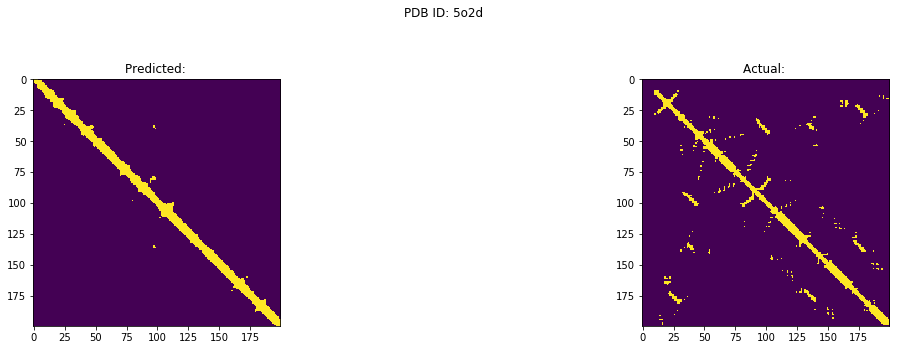

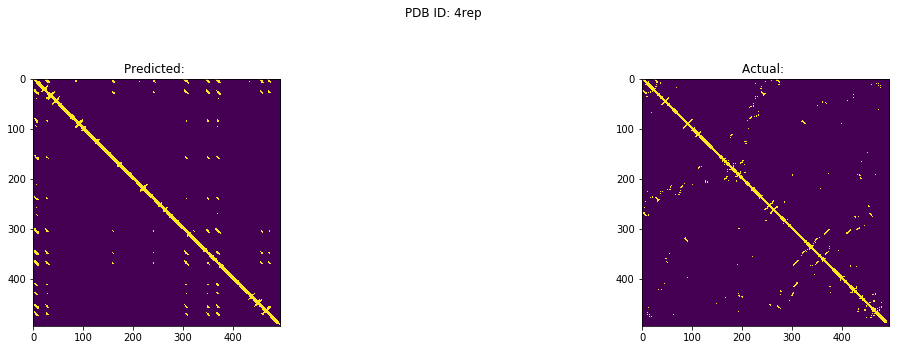

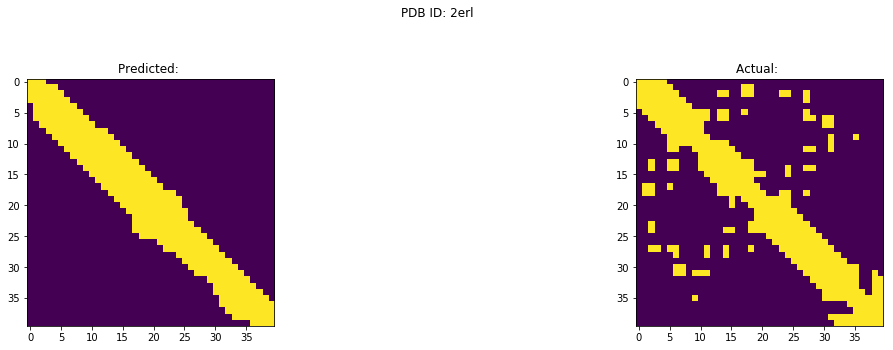

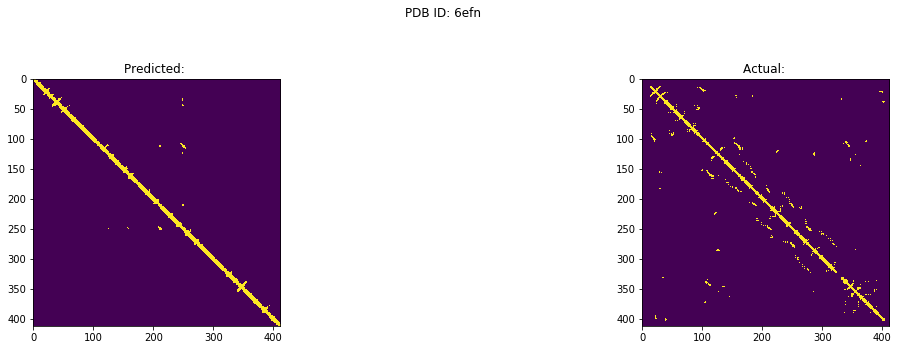

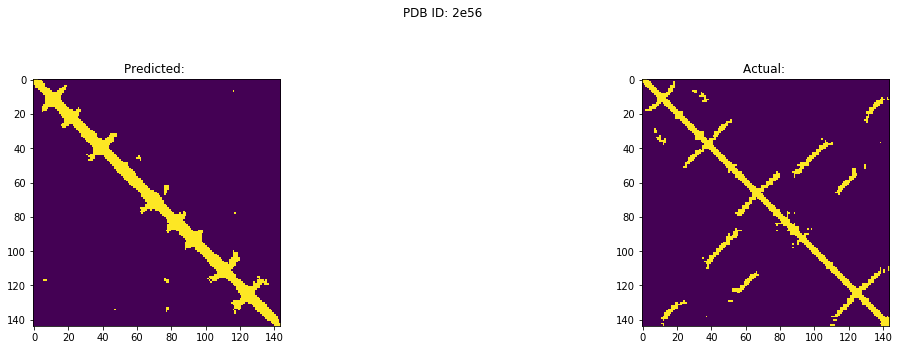

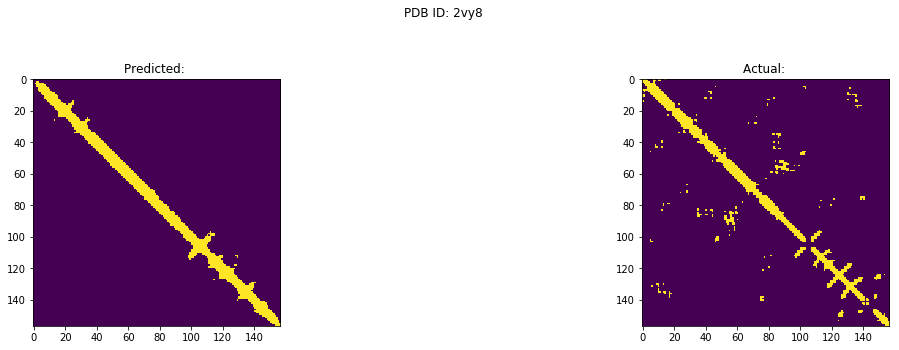

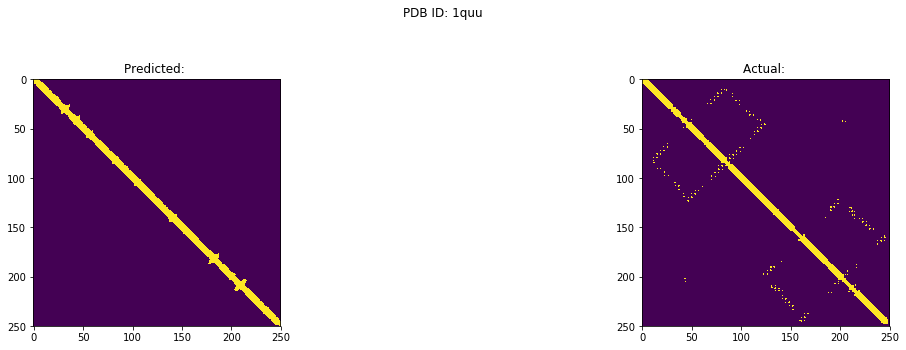

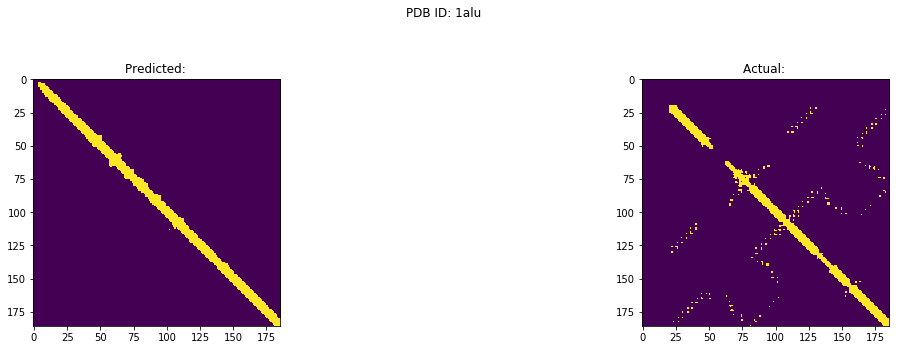

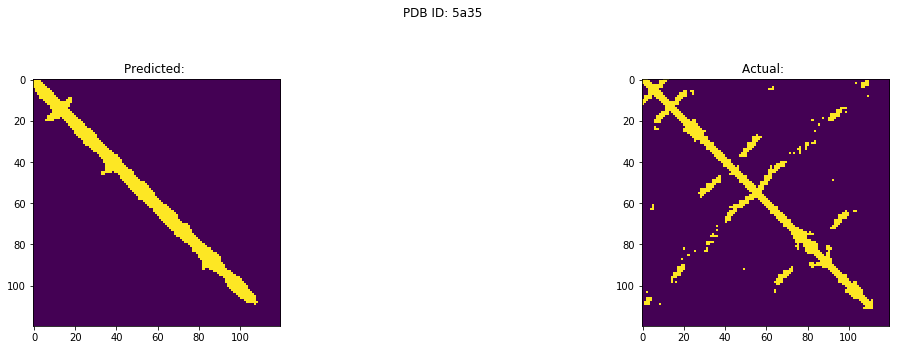

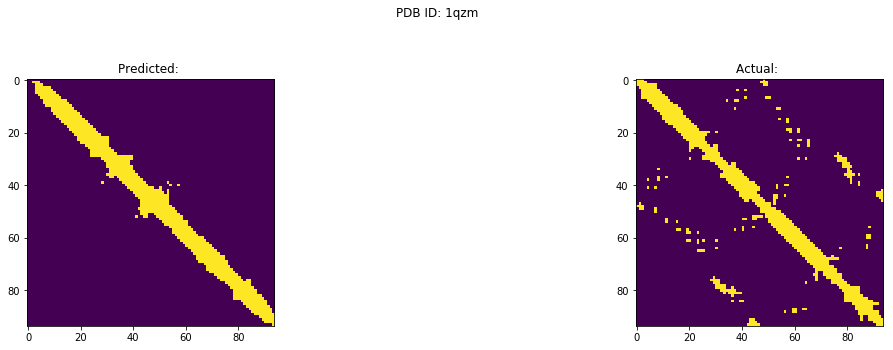

In [16]:
plot_contact_maps(c_map_preds, cmap_subdict, save_dir="plots/")

In [26]:
def contacts_in_RR_format(contact_map, threshold=8):
    """
    Convert the contact map matrix into the RR format.
    (Note that this is currently unordered)

    Format is:

    i  j  d1  d2  p

    i, j are the indices of the residues in contact.
    i < j (since the matrix is symmetrical)

    d1 and d2 indicates the threshold for contact.
    d1 = 0, d2 = 8 Angstrom is the norm.

    p indicates the probability of the two residues 
    in contact. (0.0-1.0)
    Contacts should be listed in decreasing order

    Any pair not listed is considered to not be in contact

    See here for more information:
    http://predictioncenter.org/casp13/index.cgi?page=format

    CONFOLD server requires:
        E-mail Address
        Job Id
        Sequence
        Secondary Structure
        Contacts
        
    :param contact_map: contact matrix
    :type  contact_map: numpy array
    :param threshold: threshold of contact
    :param threshold: int
    :returns: a string in the correct format
    :rtype:   str
    """

    df = pd.DataFrame(contact_map)
    columns = df.columns

    contacts = {}
    for index, row in df.iterrows():
        for col_num, col in enumerate(columns):
            prob = row[col]
            if prob > 0.5:
                min1 = min(index, col_num)
                max1 = max(index, col_num)
                contacts[str(min1) + ' ' + str(max1)] = prob
    contact_str = ""
    for resids, prob in contacts.items():
        contact_str += resids + " 0 " + str(threshold) + " " + str(prob) + '\n'
    return contact_str


def write_out_all_predictions(cmaps, path='coordinate_prediction/', maxlen=500):
    """
    Write out the information for all the inputs
    required for PDB file reconstruction.

    Since Confold server only takes in proteins of maximum length 500,
    we will impose a cap.

    :param cmaps: dictionary mapping PDB ID to cmap
    :type  cmaps: dict
    :param path: path to write out
    :type  path: str
    :param 
    """

    import os

    for pdb_id, cmap in cmaps.items():
        length = int((cmap.shape[0]))

        if length < maxlen:
            if not os.path.exists(path):
                os.makedirs(path)

            out = contacts_in_RR_format(cmap)
            out_file = open(path + pdb_id + '.txt', "w+")
            out_file.write(out)
            out_file.close()

In [27]:
write_out_all_predictions(c_map_preds)

In [28]:
print(contacts_in_RR_format (c_map_preds['5o2d']))

0 0 0 8 0.5238514
0 1 0 8 0.54435426
1 1 0 8 0.6047383
1 2 0 8 0.62153375
1 3 0 8 0.6094485
2 2 0 8 0.65762806
2 3 0 8 0.6733979
2 4 0 8 0.6104219
2 5 0 8 0.55272365
2 6 0 8 0.54027116
3 3 0 8 0.7609923
3 4 0 8 0.6690851
3 5 0 8 0.6669946
3 6 0 8 0.5259171
3 7 0 8 0.5344981
3 8 0 8 0.5156643
4 4 0 8 0.79373455
4 5 0 8 0.7858651
4 6 0 8 0.75334156
4 7 0 8 0.65185577
4 8 0 8 0.58496743
4 9 0 8 0.5175841
5 5 0 8 0.85639787
5 6 0 8 0.87772006
5 7 0 8 0.8445321
5 8 0 8 0.6731005
5 9 0 8 0.7241148
6 6 0 8 0.91672087
6 7 0 8 0.9241726
6 8 0 8 0.86644346
6 9 0 8 0.5829274
6 10 0 8 0.70712286
7 7 0 8 0.9515958
7 8 0 8 0.96521854
7 9 0 8 0.89938235
7 10 0 8 0.5756429
7 11 0 8 0.6438569
8 8 0 8 0.98513514
8 9 0 8 0.98493844
8 10 0 8 0.94717884
8 11 0 8 0.61681944
8 12 0 8 0.6832019
9 9 0 8 0.9906739
9 10 0 8 0.99028134
9 11 0 8 0.97007895
9 12 0 8 0.6844601
9 13 0 8 0.5141039
9 14 0 8 0.54666823
10 10 0 8 0.99457735
10 11 0 8 0.99358034
10 12 0 8 0.9668889
10 13 0 8 0.7284224
10 14 0 8 0.6623401
